In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'

EXPERIMENTS = {
    'MOTOR'      : {'runs': [5,6],   'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'runs': [7,8],   'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'runs': [9,10],  'cond':['fear','neut']},
    'GAMBLING'   : {'runs': [11,12], 'cond':['loss','win']},
    'LANGUAGE'   : {'runs': [13,14], 'cond':['math','story']},
    'RELATIONAL' : {'runs': [15,16], 'cond':['match','relation']},
    'SOCIAL'     : {'runs': [17,18], 'cond':['mental','rnd']}
}

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)



fname = "hcp_task.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/s4h8j/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1



regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)





In [2]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int):      0-based subject ID to load
    experiment (str):   Name of experiment 
    run (int):          0-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = EXPERIMENTS[experiment]['runs'][run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (int): 0-based subject ID to load
    experiment (str) : Name of experiment

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = 'tfMRI_'+experiment+'_'+['RL','LR'][run]
  for cond in EXPERIMENTS[experiment]['cond']:    
    ev_file  = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list



In [3]:
my_exp  = 'GAMBLING'
my_subj = 0
my_run  = 1

data = load_single_timeseries(subject=my_subj,experiment=my_exp,run=my_run,remove_mean=True)
print(data.shape)

(360, 253)


In [4]:
evs = load_evs(subject=my_subj, experiment=my_exp,run=my_run)

In [5]:
# we need a little function that averages all frames from any given condition

def average_frames(data, evs, experiment, cond):    
    idx = EXPERIMENTS[experiment]['cond'].index(cond)
    return np.mean(np.concatenate([np.mean(data[:,evs[idx][i]],axis=1,keepdims=True) for i in range(len(evs[idx]))],axis=-1),axis=1)


win_activity = average_frames(data, evs, my_exp, 'win')
loss_activity = average_frames(data, evs, my_exp, 'loss')
contrast    = win_activity-loss_activity   

In [6]:
EXPERIMENTS[my_exp]['cond'].index('loss')

0

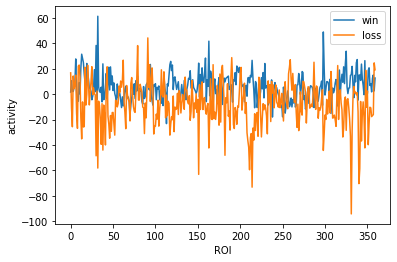

In [7]:
plt.plot(win_activity,label='win')
plt.plot(loss_activity,label='loss')
plt.xlabel('ROI')
plt.ylabel('activity')
plt.legend()

# **The GLM Estimation**

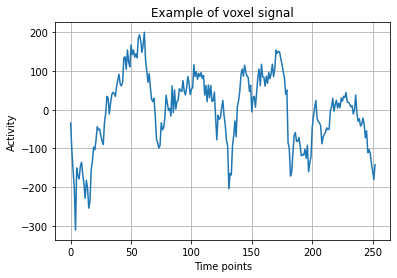

In [8]:
#the y variable in fMRI data is the timeseries

#lets take a look at the time series for region 1

plt.plot(data[0])
plt.xlabel('Time points')
plt.ylabel('Activity')
plt.title('Example of voxel signal')
plt.grid()
plt.show()

An EV file (EV:Explanatory Variable) describes the task experiment in terms of stimulus onset, duration, and amplitude. These can be used to model the task time series data.

In [9]:
evs = load_evs(subject=my_subj, experiment=my_exp,run=my_run)
len(evs[0][0])

39

In [10]:
evs[1]

[array([ 72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
         85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110]),
 array([193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,
        219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231])]

In [11]:
onsets_all = np.concatenate((evs[0][0] , evs[0][1]))
onsets_all

array([ 11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
        24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,
        37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171])

In [12]:
print(f'experiment lasts {len(data[0])} seconds')
predictor_all = np.zeros(len(data[0]))
predictor_all[onsets_all] = 1

experiment lasts 253 seconds


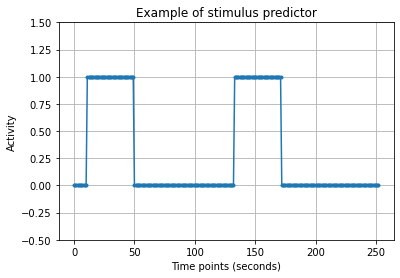

In [13]:
plt.plot(predictor_all, marker='.')
plt.xlabel('Time points (seconds)')
plt.ylabel('Activity')
plt.ylim(-.5, 1.5)
plt.title('Example of stimulus predictor')
plt.grid()
plt.show()

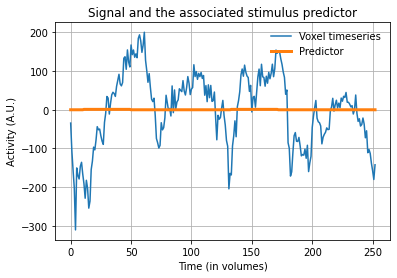

In [14]:
plt.plot(data[0])
plt.plot(predictor_all + data[0].mean(), lw=3)
plt.xlabel('Time (in volumes)')
plt.ylabel('Activity (A.U.)')
plt.legend(['Voxel timeseries', 'Predictor'], loc='upper right', frameon=False)
plt.title("Signal and the associated stimulus predictor")
plt.grid()
plt.show()

In [15]:
!pip install nilearn

     |████████████████████████████████| 4.9 MB 5.2 MB/s 


In [16]:
from nilearn.glm.first_level.hemodynamic_models import glover_hrf

/usr/local/lib/python3.7/dist-packages/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'It may change in any future release of Nilearn.', FutureWarning)


In [17]:
TR = 0.72
osf = 2
length_hrf = 32  # sec

canonical_hrf = glover_hrf(tr=TR, oversampling=osf, time_length=length_hrf, onset=0)
canonical_hrf /= canonical_hrf.max()
print("Size of canonical hrf variable: %i" % canonical_hrf.size)

Size of canonical hrf variable: 89


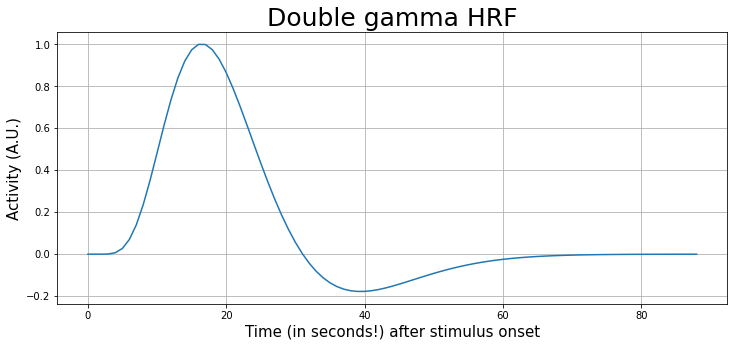

In [18]:
t = np.arange(0, canonical_hrf.size)

plt.figure(figsize=(12, 5))
plt.plot(t, canonical_hrf)
plt.xlabel('Time (in seconds!) after stimulus onset', fontsize=15)
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.title('Double gamma HRF', fontsize=25)
plt.grid()
plt.show()

In [19]:
'''We need to "squeeze" out the extra singleton axis, because that's
what the np.convolve function expects, i.e., arrays of shape (N,) and NOT (N, 1)
To go from (N, 1) --> (N,) we'll use the squeeze() method'''
predictor_conv = np.convolve(predictor_all.squeeze(), canonical_hrf)

print("The shape of the convolved predictor after convolution: %s" % (predictor_conv.shape,))

# After convolution, we also neem to "trim" off some excess values from
# the convolved signal (the reason for this is not important to understand)
predictor_conv = predictor_conv[:predictor_all.size]

print("After trimming, the shape is: %s" % (predictor_conv.shape,))

# And we have to add a new axis again to go from shape (N,) to (N, 1),
# which is important for stacking the intercept, later
predictor_conv = predictor_conv[:, np.newaxis]

print("Shape after adding the new axis: %s" % (predictor_conv.shape,))

The shape of the convolved predictor after convolution: (341,)
After trimming, the shape is: (253,)
Shape after adding the new axis: (253, 1)


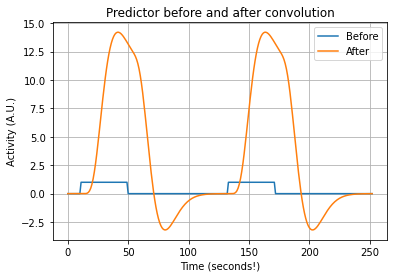

In [20]:
plt.plot(predictor_all)
plt.plot(predictor_conv)
plt.title("Predictor before and after convolution")
plt.xlabel("Time (seconds!)")
plt.ylabel("Activity (A.U.)")
plt.legend(['Before', 'After'], loc='upper right')
plt.grid()
plt.show()

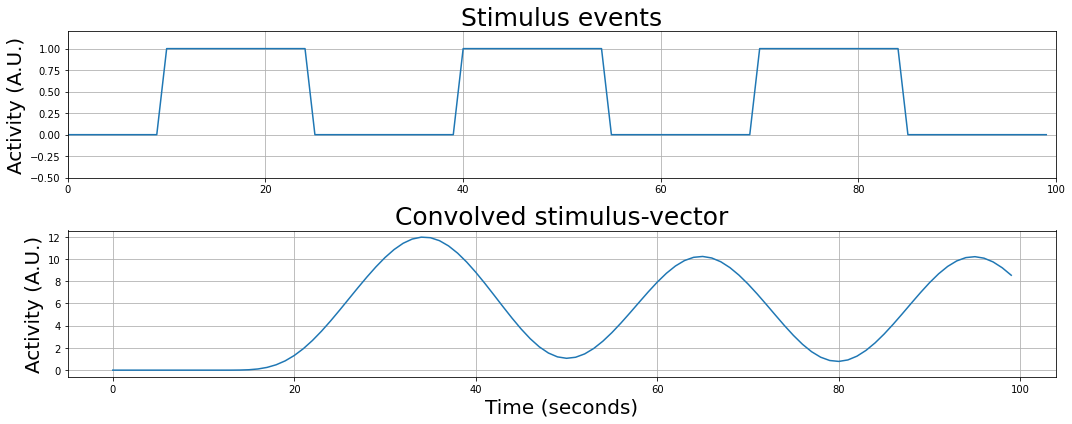

In [21]:
random_stimulus_onsets2 = list(range(10, 25)) + list(range(40, 55)) + list(range(70, 85))
random_stim_vector2 = np.zeros(100)

random_stim_vector2[random_stimulus_onsets2] = 1

plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.grid()
plt.plot(random_stim_vector2, c='tab:blue')

plt.xlim((0, 100))
plt.ylim((-.5, 1.2))
plt.ylabel('Activity (A.U.)', fontsize=20)

plt.title('Stimulus events', fontsize=25)

convolved_stim_vector2 = np.convolve(random_stim_vector2, canonical_hrf)[:random_stim_vector2.size]
plt.subplot(2, 1, 2)
plt.plot(convolved_stim_vector2)
plt.title('Convolved stimulus-vector', fontsize=25)
plt.ylabel('Activity (A.U.)', fontsize=20)
plt.xlabel('Time (seconds)', fontsize=20)
plt.grid()
plt.tight_layout()
plt.show()

In [22]:
print("Size convolved predictor: %i" % predictor_conv.size)


Size convolved predictor: 253


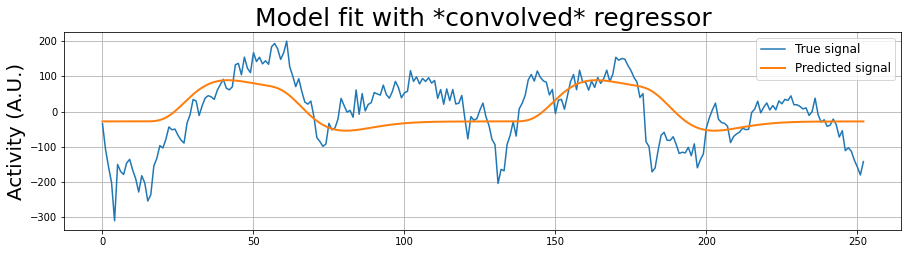

In [23]:
from numpy.linalg import inv
if predictor_conv.ndim == 1:
    # Add back a singleton axis (which was removed before downsampling)
    # otherwise stacking will give an error
    predictor_conv = predictor_conv[:, np.newaxis]

intercept = np.ones((predictor_conv.size, 1))
X_conv = np.hstack((intercept, predictor_conv))
betas_conv = inv(X_conv.T @ X_conv) @ X_conv.T @ data[0]

plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(data[0])
plt.plot(X_conv @ betas_conv, lw=2)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.title("Model fit with *convolved* regressor", fontsize=25)
plt.legend(['True signal', 'Predicted signal'], fontsize=12, loc='upper right')
plt.grid()

plt.show()

In [24]:
TR = 0.72
osf = 2
length_hrf = 32  # sec

canonical_hrf = glover_hrf(tr=TR, oversampling=osf, time_length=length_hrf, onset=0)
canonical_hrf /= canonical_hrf.max()




def betaCoeffsRun1(hrf):
  betaCoefficientsLoss = []
  betaCoefficientsWin = []
  
  for i in range(len(subjects)):
    
    my_exp  = 'GAMBLING'
    my_subj = i
    my_run  = 0
    evs = load_evs(subject=my_subj, experiment=my_exp,run=my_run)
    onsets_loss = np.concatenate((evs[0][0] , evs[0][1]))
    onsets_win = np.concatenate((evs[1][0] , evs[1][1]))


    canonical_hrf = hrf
    data = load_single_timeseries(subject=my_subj,experiment=my_exp,run=my_run,remove_mean=True)

    predictor_loss = np.zeros(len(data[0]))
    predictor_loss[onsets_loss] = 1
    
    predictor_win = np.zeros(len(data[0]))
    predictor_win[onsets_win] = 1

    predictor_convLoss = np.convolve(predictor_loss.squeeze(), canonical_hrf)
    predictor_convLoss = predictor_convLoss[:predictor_loss.size]
    predictor_convLoss = predictor_convLoss[:, np.newaxis]
    
    predictor_convWin = np.convolve(predictor_win.squeeze(), canonical_hrf)
    predictor_convWin = predictor_convWin[:predictor_win.size]
    predictor_convWin = predictor_convWin[:, np.newaxis]
    

    betaCoeffForPersonLoss = []
    betaCoeffForPersonWin = []

    for k in range(len(data)):
     
      intercept = np.ones((predictor_conv.size, 1))
      X_conv = np.hstack((intercept, predictor_convLoss,predictor_convWin))
      betas_conv = inv(X_conv.T @ X_conv) @ X_conv.T @ data[k]
      betaCoeffForPersonLoss.append(betas_conv[1])
      betaCoeffForPersonWin.append(betas_conv[2])
    
    betaCoefficientsLoss.append(betaCoeffForPersonLoss)
    betaCoefficientsWin.append(betaCoeffForPersonWin)
  
  return betaCoefficientsLoss , betaCoefficientsWin

betasLoss , betasWin = betaCoeffsRun1(canonical_hrf)

betasLoss = np.array(betasLoss)

betasWin = np.array(betasWin)

print(f'shape of betasWin: {betasWin.shape} , shape of betasLoss: {betasLoss.shape}')




    


      












shape of betasWin: (339, 360) , shape of betasLoss: (339, 360)


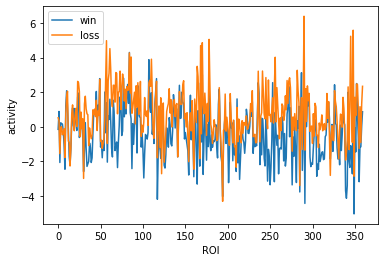

In [25]:
plt.plot(betasWin[1],label='win')
plt.plot(betasLoss[1],label='loss')
plt.xlabel('ROI')
plt.ylabel('activity')
plt.legend()

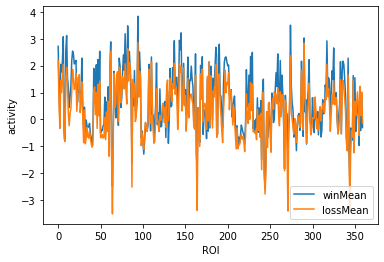

In [26]:
betasWinMean = np.mean(betasWin , axis = 0)

betasLossMean = np.mean(betasLoss , axis = 0)

plt.plot(betasWinMean,label='winMean')
plt.plot(betasLossMean,label='lossMean')
plt.xlabel('ROI')
plt.ylabel('activity')
plt.legend()

In [27]:
from scipy import stats
stats.ttest_ind(betasWinMean, betasLossMean)


Ttest_indResult(statistic=3.8170751637416296, pvalue=0.00014669382583061297)

shape of betasWin: (339, 360) , shape of betasLoss: (339, 360)


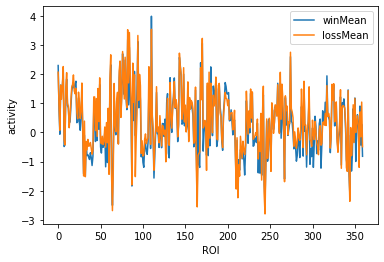

In [28]:
TR = 0.72
osf = 2
length_hrf = 32  # sec

canonical_hrf = glover_hrf(tr=TR, oversampling=osf, time_length=length_hrf, onset=0)
canonical_hrf /= canonical_hrf.max()




def betaCoeffsRun2(hrf):
  betaCoefficientsLoss = []
  betaCoefficientsWin = []
  
  for i in range(len(subjects)):
    
    my_exp  = 'GAMBLING'
    my_subj = i
    my_run  = 1
    evs = load_evs(subject=my_subj, experiment=my_exp,run=my_run)
    onsets_loss = np.concatenate((evs[0][0] , evs[0][1]))
    onsets_win = np.concatenate((evs[1][0] , evs[1][1]))


    canonical_hrf = hrf
    data = load_single_timeseries(subject=my_subj,experiment=my_exp,run=my_run,remove_mean=True)

    predictor_loss = np.zeros(len(data[0]))
    predictor_loss[onsets_loss] = 1
    
    predictor_win = np.zeros(len(data[0]))
    predictor_win[onsets_win] = 1

    predictor_convLoss = np.convolve(predictor_loss.squeeze(), canonical_hrf)
    predictor_convLoss = predictor_convLoss[:predictor_loss.size]
    predictor_convLoss = predictor_convLoss[:, np.newaxis]
    
    predictor_convWin = np.convolve(predictor_win.squeeze(), canonical_hrf)
    predictor_convWin = predictor_convWin[:predictor_win.size]
    predictor_convWin = predictor_convWin[:, np.newaxis]
    

    betaCoeffForPersonLoss = []
    betaCoeffForPersonWin = []

    for k in range(len(data)):
     
      intercept = np.ones((predictor_conv.size, 1))
      X_conv = np.hstack((intercept, predictor_convLoss,predictor_convWin))
      betas_conv = inv(X_conv.T @ X_conv) @ X_conv.T @ data[k]
      betaCoeffForPersonLoss.append(betas_conv[1])
      betaCoeffForPersonWin.append(betas_conv[2])
    
    betaCoefficientsLoss.append(betaCoeffForPersonLoss)
    betaCoefficientsWin.append(betaCoeffForPersonWin)
  
  return betaCoefficientsLoss , betaCoefficientsWin

betasLoss2 , betasWin2 = betaCoeffsRun2(canonical_hrf)

betasLoss2 = np.array(betasLoss2)

betasWin2 = np.array(betasWin2)

print(f'shape of betasWin: {betasWin2.shape} , shape of betasLoss: {betasLoss2.shape}')




    


      
betasWinMean2 = np.mean(betasWin2 , axis = 0)

betasLossMean2 = np.mean(betasLoss2 , axis = 0)

plt.plot(betasWinMean2,label='winMean')
plt.plot(betasLossMean2,label='lossMean')
plt.xlabel('ROI')
plt.ylabel('activity')
plt.legend()











In [29]:
stats.ttest_ind(betasWinMean2, betasLossMean2)

Ttest_indResult(statistic=-1.591247371720041, pvalue=0.11199407108277294)

In [35]:
betasWinAll = np.concatenate((betasWin , betasWin2))
betasLossAll = np.concatenate((betasLoss , betasLoss2))

np.save('betasWinNumpy.npy' , betasWinAll)
# np.save('betasLossNumpy.npy' , betasLossAll)

In [31]:
betasWinAll.shape

(678, 360)

In [33]:
np.save('betasWinNumpy' , betasWinAll)
np.save('betasLossNumpy' , betasLossAll)